## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [56]:
# general imports
import time
import types
import os
from shutil import copyfile, copy

# ML stuff
import numpy as np
from matplotlib.image import imread

# PyTorch stuff
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

# custom utils
from logger import TBLogger
from extract_patches import *
from pytorch_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
debug_vals = types.SimpleNamespace()

In [58]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model

In [59]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=20, H=16, W=16):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

In [90]:
class ConvAutoencoderV2(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(20, 25, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            Flatten(),
        )
        
        self.decoder = nn.Sequential(
            Unflatten(C=25, H=8, W=8),
            
            nn.ConvTranspose2d(25, 20, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(20, 15, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(15, 10, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(5, image_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

summary(ConvAutoencoderV2().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
         LeakyReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
         LeakyReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
         LeakyReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
         LeakyReLU-8           [-1, 20, 16, 16]               0
            Conv2d-9             [-1, 25, 8, 8]          12,525
        LeakyReLU-10             [-1, 25, 8, 8]               0
          Flatten-11                 [-1, 1600]               0
        Unflatten-12             [-1, 25, 8, 8]               0
  ConvTranspose2d-13           [-1, 20, 16, 16]           8,020
        LeakyReLU-14           [-1, 20,

### Data Loader

In [91]:
from itertools import cycle
from os import listdir
from os.path import isfile, join

In [92]:
data_path = './data'
files_per_epoch = 7

# get all red files
red_img_files = [f for f in listdir(data_path)
                 if isfile(join(data_path, f)) and 'RED' in f]

# random shuffle
np.random.seed(42)
np.random.shuffle(red_img_files)

# get groups of files
epoch_files = np.array_split(red_img_files, int(len(red_img_files) / files_per_epoch))

In [93]:
def get_new_epoch_patches(files_iterator, batch_size=16, patch_size=256):
    # list of .IMG files names
    epoch_files = next(files_iterator).tolist()

    # extract patches and concatenate all of them into one list
    images, ids = extract_patches_from_img(epoch_files, patch_size=256)
    
    # numpy to tensor
    tensor_images = numpy_images_to_tensor_dataset(images)
    
    # create loader for PyTorch
    dataset = torch.utils.data.TensorDataset(tensor_images)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    return loader

#### finding the path to current notebook file, so we can copy the notebook to log directory

In [94]:
%%javascript 
var kernel = Jupyter.notebook.kernel; 
var command = ["current_notebook_path = ",
               "'", decodeURIComponent(window.document.body.dataset.notebookPath), "'" ].join('')

kernel.execute(command)

<IPython.core.display.Javascript object>

In [100]:
# images used for logging and testing
log_images = None

def train_model(log_name, print_interval=5):
    global log_images
    
    log_dir = './logs/' + log_name
    
    # make sure we are not training in existing directory
    if os.path.isdir(log_dir):
        raise ValueError('Please, use a new logging directory for training')
    
    # make a new logger for new directory
    tb_logger = TBLogger(log_dir)
    
    # make a copy so you we can recall what/how exactly we trained this time
    copy(current_notebook_path, log_dir)
    
    # get looper over epoch files
    epoch_files_iterator = cycle(epoch_files)
    
    # now we can start the training
    model.train()
    
    for epoch in range(num_epochs):
        losses = []
        
        # using the cyclic iterator get a new group of images
        # split them into patches, combine to one list
        # and convert this list into PyTorch dataset
        loader = get_new_epoch_patches(epoch_files_iterator)
        
        # loop over mini-batches sampled from patches in current dataset
        for i, (data,) in enumerate(loader):
            
            # store some images to track the training progress
            if log_images is None:
                log_images = data.clone()
            
            data = data.to(device)

            # forward
            output = model(data)

            # compute MSE loss
            loss = criterion(output, data)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        
        # get mean averaged per mini-batch
        mean_loss = np.mean(losses)
        
        # log to file on every epoch
        tb_logger.add_loss(mean_loss)
        
        # log to console from time to time
        if epoch % print_interval == 0:
            print(time.strftime('%X') + ' - epoch [{}/{}], loss:{:.8f}'.format(epoch+1, num_epochs, mean_loss))
            
            # save the model for myself and model state for sharing with others
            torch.save(model, f'{log_dir}/model_e_{epoch}.model')
            torch.save(model.state_dict(), f'{log_dir}/model_e_{epoch}.pth')
            
            save_test_img(f'{log_dir}/e_{epoch}_image.jpg', model, log_images)
    
    # saving the final model
    torch.save(model, f'{log_dir}/model_e_{epoch}.model')
    torch.save(model.state_dict(), f'{log_dir}/model_v2_e_{epoch}.pth')
    
    print('DONE')

def save_test_img(fname, model, tensor_images):
    test_data = tensor_images[3:4]
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)
    np_output = test_output.data.cpu().numpy()
    
    # we need this if last activation is ReLU
    np_output[np_output > 255] = 255
    
    plt.imsave(fname, np.squeeze(np_output), cmap='afmhot')

## Training
### Please, use new logging directory name  before each training!

In [96]:
criterion = nn.MSELoss()
learning_rate = 1e-3

In [97]:
import warnings
warnings.filterwarnings('ignore')

### Running for the first time

In [101]:
num_epochs = 500

# reseting the model
model = ConvAutoencoderV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# specify a new name for log directory!
train_model('cae_v5_lrelu_16')

23:19:18 - epoch [1/500], loss:17284.58850882
23:20:28 - epoch [6/500], loss:6270.59101219
23:21:36 - epoch [11/500], loss:4711.63220159
23:22:45 - epoch [16/500], loss:2934.97392600
23:23:58 - epoch [21/500], loss:1190.61814558
23:25:16 - epoch [26/500], loss:147.29276041
23:26:24 - epoch [31/500], loss:100.33946236
23:27:36 - epoch [36/500], loss:47.44988060
23:28:45 - epoch [41/500], loss:40.96569136
23:29:56 - epoch [46/500], loss:18.75754011
23:31:03 - epoch [51/500], loss:26.41027621
23:32:09 - epoch [56/500], loss:10.36755854
23:33:14 - epoch [61/500], loss:21.11452406
23:34:23 - epoch [66/500], loss:7.26383326
23:35:28 - epoch [71/500], loss:19.06000982
23:36:33 - epoch [76/500], loss:6.03193103
23:37:38 - epoch [81/500], loss:18.14472876
23:38:45 - epoch [86/500], loss:5.44309101
23:39:50 - epoch [91/500], loss:17.63930192
23:41:01 - epoch [96/500], loss:5.10922551
23:42:05 - epoch [101/500], loss:17.31613502
23:43:12 - epoch [106/500], loss:4.89778890
23:44:18 - epoch [111/50

### Continue training of the *same* model

In [ ]:
num_epochs = 500

train_model('cae_v5_lrelu_12.4')

### Running from scratch

In [102]:
num_epochs = 2000

# create new model and new optimizer
model = ConvAutoencoderV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                             weight_decay=1e-6)

train_model('cae_v5_lrelu_17')

01:07:00 - epoch [1/2000], loss:7170.91958926
01:08:04 - epoch [6/2000], loss:88.76065694
01:09:07 - epoch [11/2000], loss:35.16238949
01:10:11 - epoch [16/2000], loss:9.74772633
01:11:14 - epoch [21/2000], loss:19.80191330
01:12:18 - epoch [26/2000], loss:5.94075181
01:13:20 - epoch [31/2000], loss:17.81406898
01:14:24 - epoch [36/2000], loss:5.08296149
01:15:27 - epoch [41/2000], loss:17.50005694
01:16:31 - epoch [46/2000], loss:4.69269189
01:17:34 - epoch [51/2000], loss:17.45890252
01:18:38 - epoch [56/2000], loss:4.49350875
01:19:40 - epoch [61/2000], loss:16.39188738
01:20:44 - epoch [66/2000], loss:4.42343875
01:21:46 - epoch [71/2000], loss:16.17326309
01:22:50 - epoch [76/2000], loss:4.28442504
01:23:52 - epoch [81/2000], loss:15.79591764
01:24:56 - epoch [86/2000], loss:4.19751638
01:25:59 - epoch [91/2000], loss:15.42403963
01:27:03 - epoch [96/2000], loss:4.28876181
01:28:05 - epoch [101/2000], loss:15.70192102
01:29:09 - epoch [106/2000], loss:4.16870721
01:30:12 - epoch [

04:18:22 - epoch [906/2000], loss:2.93823350
04:19:25 - epoch [911/2000], loss:7.04114044
04:20:30 - epoch [916/2000], loss:2.78228571
04:21:33 - epoch [921/2000], loss:7.01531545
04:22:38 - epoch [926/2000], loss:2.77846538
04:23:41 - epoch [931/2000], loss:7.02058943
04:24:46 - epoch [936/2000], loss:2.77478299
04:25:49 - epoch [941/2000], loss:6.98490451
04:26:54 - epoch [946/2000], loss:2.77151264
04:27:57 - epoch [951/2000], loss:6.97078178
04:29:03 - epoch [956/2000], loss:2.76632052
04:30:06 - epoch [961/2000], loss:7.29259454
04:31:13 - epoch [966/2000], loss:2.77566402
04:32:15 - epoch [971/2000], loss:6.93989985
04:33:22 - epoch [976/2000], loss:2.75829538
04:34:25 - epoch [981/2000], loss:6.94098913
04:35:31 - epoch [986/2000], loss:2.75595158
04:36:34 - epoch [991/2000], loss:6.93018275
04:37:40 - epoch [996/2000], loss:2.75192253
04:38:43 - epoch [1001/2000], loss:6.91586952
04:39:49 - epoch [1006/2000], loss:2.74811116
04:40:52 - epoch [1011/2000], loss:6.89057243
04:41:5

07:33:58 - epoch [1796/2000], loss:2.47917925
07:35:01 - epoch [1801/2000], loss:6.01564503
07:36:08 - epoch [1806/2000], loss:2.49804284
07:37:10 - epoch [1811/2000], loss:5.95285220
07:38:17 - epoch [1816/2000], loss:2.55022539
07:39:19 - epoch [1821/2000], loss:5.92525392
07:40:26 - epoch [1826/2000], loss:2.54563929
07:41:30 - epoch [1831/2000], loss:5.90528189
07:42:36 - epoch [1836/2000], loss:2.48954724
07:43:39 - epoch [1841/2000], loss:5.98602458
07:44:46 - epoch [1846/2000], loss:2.44155720
07:45:50 - epoch [1851/2000], loss:5.86136384
07:46:57 - epoch [1856/2000], loss:2.43620758
07:48:01 - epoch [1861/2000], loss:5.90321790
07:49:08 - epoch [1866/2000], loss:2.51175871
07:50:11 - epoch [1871/2000], loss:5.81134238
07:51:18 - epoch [1876/2000], loss:2.42056628
07:52:21 - epoch [1881/2000], loss:5.81666354
07:53:28 - epoch [1886/2000], loss:2.42002947
07:54:31 - epoch [1891/2000], loss:5.84709163
07:55:38 - epoch [1896/2000], loss:2.40871721
07:56:42 - epoch [1901/2000], loss

### Test

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

In [30]:
def test_model(img):
    model.eval()
    test_data = img
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)

    # a = test_output.data
    imshow(test_output.data.cpu().numpy())

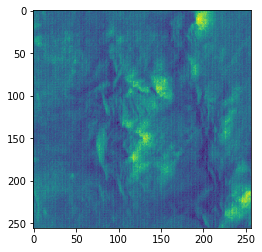

In [63]:
# model = ConvAutoencoderV2().to(device)
imshow(log_images[5:6])

In [ ]:
test_model(log_images[5:6])